<a href="https://colab.research.google.com/github/BharathSD/CPP_Practice_Problems/blob/master/Telecom_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn Case Study

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.



## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import math

# display/ plot libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# sklearn related imports
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

### google drive mount related imports
needed only for colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data

In [ ]:
# define path to the data
drivePath = '/content/drive/My Drive/Masters/telecom_churn/'
path = drivePath + 'telecom_churn_data.csv'


In [ ]:
telecom = pd.read_csv(path)

In [ ]:
telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,...,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.0,0.0,0.0,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,...,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,28.61,7.60,NaN,NaN,0.0,0.0,NaN,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.0,0.00,0.00,38.49,0.0,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,...,0.00,0.00,8.42,NaN,NaN,NaN,2.84,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.0,54.86,44.38,0.00,0.0,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,...,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [ ]:
telecom.shape

(99999, 226)

In [ ]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [ ]:
telecom.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,92254.000000,96062.000000,96140.000000,94621.000000,...,99999.000000,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,132.395875,133.670805,133.018098,130.302327,197.935577,197.045133,196.574803,190.337222,9.950013,7.149898,7.292981,6.343841,13.911337,9.818732,9.971890,8.555519,47.100763,46.473010,45.887806,44.584446,93.342088,91.397131,91.755128,90.463192,3.751013,3.792985,3.677991,3.655123,1.123056,1.368500,1.433821,...,128.995847,135.410689,136.056613,89.555057,89.384120,91.173849,100.264116,86.398003,85.914450,86.599478,93.712026,0.025086,0.023034,0.020844,0.015971,0.079641,0.083221,0.081001,0.068781,0.389384,0.439634,0.450075,0.393104,0.075921,0.078581,0.082941,0.086341,0.074781,0.080401,0.084501,0.084581,0.914404,0.908764,0.890808,0.860968,1219.854749,68.170248,66.839062,60.021204,3.299373
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,297.207406,308.794148,308.951589,308.477668,316.851613,325.862803,327.170662,319.396092,72.825411,73.447948,68.402466,57.137537,71.443196,58.455762,64.713221,58.438186,150.856393,155.318705,151.184830,147.995390,162.780544,157.492308,156.537048,158.681454,14.230438,14.264986,13.270996,13.457549,5.448946,7.533445,6.783335,...,541.494013,558.775335,577.394194,193.124653,195.893924,188.180936,216.291992,172.767523,176.379871,168.247852,171.384224,0.156391,0.150014,0.142863,0.125366,0.295058,0.304395,0.299568,0.278120,1.497320,1.636230,1.630263,1.347140,0.363371,0.387231,0.384947,0.384978,0.568344,0.628334,0.660234,0.650457,0.279772,0.287950,0.311885,0.345987,954.733842,267.580450,271.201856,253.938223,32.408353
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

The data has around 1 lakh samples and 226 columns.

There are two types of Churn: 
1.   **Revenue Based Churn** : Customers who have not utilised any revenue-generating facilities such as mobile internet, outgoing calls, SMS etc. over a given period of time. 
2.   **Usage Based Churn** : Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.



In this project we will be looking at only **Usage Based Churn**.The problem statement expects us to work on only High Value customers. 


In Churn Prediction there are three phases of customer lifecycle :


*   'Good Phase' [Month 6 and 7]
*   'Action Phase' [Month 8]
*   'Churn Phase' [Month 9]

In this case, since we are working over a four-month window, the first two months are 'Good Phase', the third month is 'Action Phase'and the fourth month is 'Churn Phase'.

### Derive new columns



In [ ]:
telecom.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

It can be observed that we can derive new columns from recharge related columns.

In [ ]:
recharge_amt_cols = telecom.columns[telecom.columns.str.contains('rech_amt|rech_data')]
print(recharge_amt_cols)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')


In [ ]:
recharge_cols_missing_vals = pd.DataFrame(telecom.loc[:, recharge_amt_cols].isnull().sum() / len(telecom) * 100)
recharge_cols_missing_vals.rename(columns={0:'Missing_Vals'}, inplace=True)

Lets define some style property to missing values to display

In [ ]:
def apply_color(val):
  '''
  Takes scalar values and returns a string with property
  "color:color_str" for values greater than thresh
  '''
  thresh = 5
  apply_color = 'red'
  color = apply_color if val > thresh else 'black'
  return 'color: %s'% color

In [ ]:
recharge_cols_missing_vals = recharge_cols_missing_vals.style.applymap(apply_color)
recharge_cols_missing_vals

,Missing_Vals
total_rech_amt_6,0.000000
total_rech_amt_7,0.000000
total_rech_amt_8,0.000000
total_rech_amt_9,0.000000
max_rech_amt_6,0.000000
max_rech_amt_7,0.000000
max_rech_amt_8,0.000000
max_rech_amt_9,0.000000
date_of_last_rech_data_6,74.846748
date_of_last_rech_data_7,74.428744


It can be observed that more than 74% of the data are missing for some recharge related columns

In [ ]:
telecom.loc[:,recharge_amt_cols].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.00000,25153.000000,25571.000000,26339.000000,25922.000000
mean,327.514615,322.962970,324.157122,303.345673,104.637486,104.752398,107.728207,101.943889,2.463802,2.666419,2.651999,2.441170,126.393392,126.729459,125.717301,124.94144,192.600982,200.981292,197.526489,192.734315
std,398.019701,408.114237,416.540455,404.588583,120.614894,124.523970,126.902505,125.375109,2.789128,3.031593,3.074987,2.516339,108.477235,109.765267,109.437851,111.36376,192.646318,196.791224,191.301305,188.400286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.500000,0.500000,1.000000
25%,109.000000,100.000000,90.000000,52.000000,30.000000,30.000000,30.000000,28.000000,1.000000,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,25.00000,82.000000,92.000000,87.000000,69.000000
50%,230.000000,220.000000,225.000000,200.000000,110.000000,110.000000,98.000000,61.000000,1.000000,1.000000,1.000000,2.000000,145.000000,145.000000,145.000000,145.00000,154.000000,154.000000,154.000000,164.000000
75%,437.500000,428.000000,434.500000,415.000000,120.000000,128.000000,144.000000,144.000000,3.000000,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,179.00000,252.000000,252.000000,252.000000,252.000000
max,35190.000000,40335.000000,45320.000000,37235.000000,4010.000000,4010.000000,4449.000000,3399.000000,61.000000,54.000000,60.000000,84.000000,1555.000000,1555.000000,1555.000000,1555.00000,7546.000000,4365.000000,4076.000000,4061.000000


From the above analysis:

*   We can create new feature 'total_rech_amt_data' using 'total_rech_data' and 'av_rech_amt_data' to capture amount utilized for data
*   The min value of 'total_rech_data' is 1, so we can safely impute NA values by 0 assuming there were no recharges done

This is a fair assumption because percentage of columns missing is same for months 6,7,8



In [ ]:
for itr in range(6,9):
  total_rech_data = 'total_rech_data_{}'.format(itr)
  telecom[total_rech_data] = telecom[total_rech_data].fillna(0.0)

  av_rech_amt = 'av_rech_amt_data_{}'.format(itr)
  telecom[av_rech_amt] = telecom[av_rech_amt].fillna(0.0)

  telecom['total_rech_amt_data_{}'.format(itr)] = telecom[total_rech_data] * telecom[av_rech_amt]  

Let us now create total average recharge amount for good phase for good phase (months 6 and 7)

In [ ]:
good_phase_months = [6,7]
cols = []
for itr in good_phase_months:
  cols.append('total_rech_amt_{}'.format(itr))
  cols.append('total_rech_amt_data_{}'.format(itr))
cols

['total_rech_amt_6',
 'total_rech_amt_data_6',
 'total_rech_amt_7',
 'total_rech_amt_data_7']

In [ ]:
telecom['total_avg_rech_amt_GPhase'] = (telecom[cols].sum(axis=1)/2.0)

In [ ]:
telecom['total_avg_rech_amt_GPhase'].head()

0    559.0
1    306.0
2    241.5
3    270.0
4    301.0
Name: total_avg_rech_amt_GPhase, dtype: float64

### Filter High value customers

**High Value Customers:**
 Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [ ]:
col_name = 'total_avg_rech_amt_GPhase'
high_val_customer_thresh = telecom[col_name].quantile(0.7)

# filter the dataframe
telecom = telecom[telecom[col_name] > high_val_customer_thresh]


In [ ]:
telecom.shape

(29953, 230)

We have only around 29.9k customers who are high value customers

### Tag churners


Tag the churned customers (churn=1, else 0) based on the fourth month as follows: 
1. Those who have not made any calls (either incoming or outgoing) 
2. Have not used mobile internet even once in the churn phase. 

The attributes to tag churners are:
* total_ic_mou_9
* total_og_mou_9
* vol_2g_mb_9
* vol_3g_mb_9

In [ ]:
# columns corresponding to churn phase (containing "_9")
cols_churnPhase = telecom.columns[telecom.columns.str.contains('_9')]
cols_churnPhase

Index(['last_date_of_month_9', 'arpu_9', 'onnet_mou_9', 'offnet_mou_9',
       'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9',
       'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9',
       'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9',
       'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9',
       'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9',
       'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9',
       'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9',
       'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9',
       'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9',
       'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9',
       'date_of_last_rech_data_9', 'total_rech_data_9', 'max_rech_data_9',
       'count_rech_2g_9', 'count_rech_3g_9', 'av_rech_amt_data_9',
       'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'arpu_2g_9',
       'night_pck_user

In [ ]:
churners_cols = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']

Let us check if NA/Null values are present 

In [ ]:
churn_cols_null_check = pd.DataFrame(telecom.loc[:,churners_cols].isnull().sum()/len(telecom))
churn_cols_null_check.rename(columns={0:'Missing_Vals'}, inplace=True)

In [ ]:
churn_cols_null_check = churn_cols_null_check.style.applymap(apply_color)
churn_cols_null_check

,Missing_Vals
total_ic_mou_9,0.000000
total_og_mou_9,0.000000
vol_2g_mb_9,0.000000
vol_3g_mb_9,0.000000


No missing values, so we can create churners data

In [ ]:
# Initially set all the values as 0
telecom['churn']= 0

In [ ]:
#is_churned boolean flag for customers where above values are zero
is_churned = (telecom.total_ic_mou_9 == 0) & \
             (telecom.total_og_mou_9 == 0) & \
             (telecom.vol_2g_mb_9 ==0) & \
             (telecom.vol_3g_mb_9 ==0)

In [ ]:
# set all which having is_churned True condition as 1
telecom.loc[is_churned,'churn']=1

In [ ]:
# lets find out churn/non churn percentage
telecom['churn'].value_counts()/len(telecom)*100

0    91.877274
1     8.122726
Name: churn, dtype: float64

There is imbalance in the data and needs to be carefully handled

Drop all the columns corresponding to churn phase (containing '_9')

In [ ]:
telecom.drop(cols_churnPhase, axis=1, inplace=True)

## Utility Functions

### Box Plot

In [ ]:
def plot_box_plot(df, attributes, figSize=(20,16)):
  plt.figure(figsize=figSize)
  for n,attribute in enumerate(attributes):
    plt.subplot(1,3,n+1)
    sns.boxplot(data=df, y=attribute, x= 'churn', hue='churn',
                showfliers=False, palette=("plasma"))
  plt.show()

### Bar Chart

In [ ]:
def plot_bar_chart(df,columns, type_='mean', figSize=(10,5),rot=0):
  df_0 = df[df.churn == 0].filter(columns)
  df_1 = df[df.churn == 1].filter(columns)

  if type_ == 'median':
    updated_df_0 = pd.DataFrame([df_0.median()],index={'Non Churn'})
    updated_df_1 = pd.DataFrame([df_1.median()],index={'Churn'})
  else:
    updated_df_0 = pd.DataFrame([df_0.mean()],index={'Non Churn'})
    updated_df_1 = pd.DataFrame([df_1.mean()],index={'Churn'})

  frames = [updated_df_0, updated_df_1]
  mean_bar = pd.concat(frames)

  mean_bar.T.plot.bar(figsize=figSize,rot=rot)
  plt.show()
    
  return mean_bar

### Heat Map

In [ ]:
def plot_heat_map(df, figSize=(15,15)):
  plt.figure(figsize=figSize)
  sns.heatmap(df.corr(), cmap='OrRd', annot=True)
  plt.show()

## EDA

In [ ]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 177 entries, mobile_number to churn
dtypes: float64(140), int64(28), object(9)
memory usage: 40.7+ MB


### Remove Multicollinear variables

In [ ]:
def remove_collinear_features(df_model, target_var, threshold, verbose=False):
  '''
  Objective:
  Remove collinear features in a dataframe with a correlation coefficient
  greater than the threshold and which have the least correlation with the 
  target (dependent) variable. Removing collinear features can help a model 
  to generalize and improves the interpretability of the model.

  Inputs: 
  df_model: features dataframe
  target_var: target (dependent) variable
  threshold: features with correlations greater than this value are removed
  verbose: set to "True" for the log printing

  Output: 
  dataframe that contains only the non-highly-collinear features
  '''

  # Calculate the correlation matrix
  corr_matrix = df_model.drop(target_var, 1).corr()
  iters = range(len(corr_matrix.columns) - 1)
  drop_cols = []
  dropped_feature = ""

  # Iterate through the correlation matrix and compare correlations
  for i in iters:
    for j in range(i+1): 
      item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
      col = item.columns
      row = item.index
      val = abs(item.values)
      # If correlation exceeds the threshold
      if val >= threshold:
        # Print the correlated features and the correlation value
        if verbose:
          print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
        col_value_corr = df_model[col.values[0]].corr(df_model[target_var])
        row_value_corr = df_model[row.values[0]].corr(df_model[target_var])
        if verbose:
          print("{}: {}".format(col.values[0], np.round(col_value_corr, 3)))
          print("{}: {}".format(row.values[0], np.round(row_value_corr, 3)))
        if col_value_corr < row_value_corr:
          drop_cols.append(col.values[0])
          dropped_feature = "dropped: " + col.values[0]
        else:
          drop_cols.append(row.values[0])
          dropped_feature = "dropped: " + row.values[0]
        if verbose:
          print(dropped_feature)
          print("----------------------------------------------------------")

  # Drop one of each pair of correlated columns
  drops = list(set(drop_cols))
    
  return drops

In [ ]:
telecom.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

### Drop columns

1. Drop columns with only one unique value or there is no variance

In [ ]:
for col in telecom.columns:
  if telecom[col].nunique() == 1:
    print('Dropping the column : "{}" as there is no variance in the data'.format(col))
    telecom.drop(col, axis=1, inplace=True)

Dropping the column : "circle_id" as there is no variance in the data
Dropping the column : "loc_og_t2o_mou" as there is no variance in the data
Dropping the column : "std_og_t2o_mou" as there is no variance in the data
Dropping the column : "loc_ic_t2o_mou" as there is no variance in the data
Dropping the column : "last_date_of_month_6" as there is no variance in the data
Dropping the column : "last_date_of_month_7" as there is no variance in the data
Dropping the column : "last_date_of_month_8" as there is no variance in the data
Dropping the column : "std_og_t2c_mou_6" as there is no variance in the data
Dropping the column : "std_og_t2c_mou_7" as there is no variance in the data
Dropping the column : "std_og_t2c_mou_8" as there is no variance in the data
Dropping the column : "std_ic_t2o_mou_6" as there is no variance in the data
Dropping the column : "std_ic_t2o_mou_7" as there is no variance in the data
Dropping the column : "std_ic_t2o_mou_8" as there is no variance in the data


In [ ]:
print('Number of Columns after removing columns having no variance : {}'.format(len(telecom.columns)))

Number of Columns after removing columns having no variance : 164


### Handle Date type columns

In [ ]:
# columns corresponding to date
date_columns = telecom.columns[telecom.columns.str.contains('date')]
date_columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')

Covert to date type

In [ ]:
for col in date_columns:
  telecom[col] = pd.to_datetime(telecom[col])

### Handle Categorical Types

Since the data has only numeric values, we can check if the number of unique values are less than 20 to find potential categorical columns

In [ ]:
potential_cat_cols = [col for col in telecom.columns if telecom[col].nunique() <= 20]
potential_cat_cols

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'churn']

Let us now perform Exploratory analysis to extract useful insights on the columns

#### Recharge amount related variables

In [ ]:
# Recharge related columns
rech_columns = telecom.columns[telecom.columns.str.contains('rech_amt')]
rech_columns

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'total_rech_amt_data_6', 'total_rech_amt_data_7',
       'total_rech_amt_data_8', 'total_avg_rech_amt_GPhase'],
      dtype='object')

##### 1. total reacharge amount

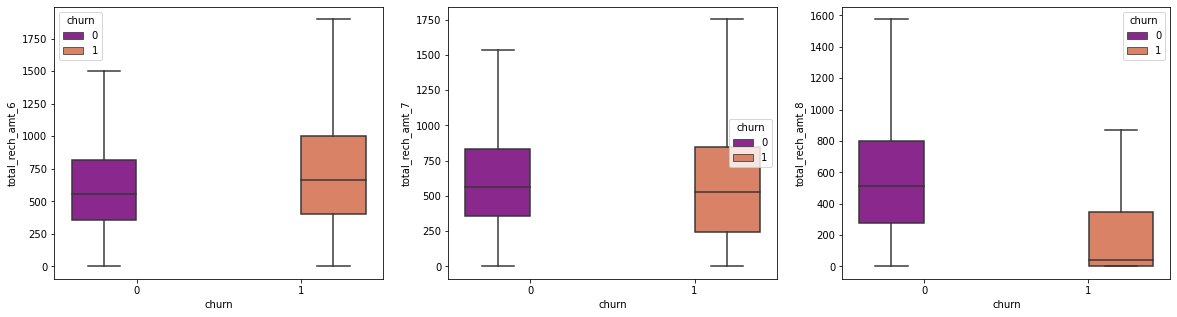

In [ ]:
# columns related to total reacharge amount
plot_box_plot(telecom,rech_columns[0:3],figSize=(20,5))

There is significant drop in the total recharge amount for the churned case in Action Phase (8th Month)

##### 2. total reacharge amount for data

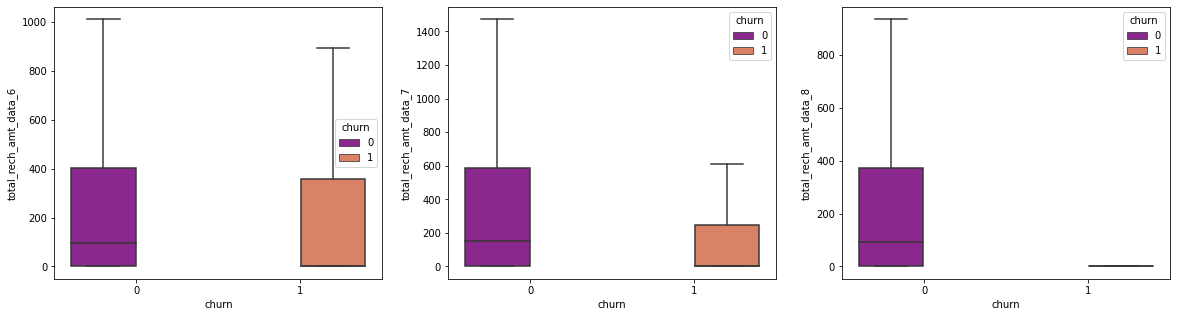

In [ ]:
plot_box_plot(telecom,rech_columns[9:12],figSize=(20,5))

There is huge drop in the total recharge amount for data for the churned case in Action Phase (8th Month)

##### 3. Maximum reacharge amount

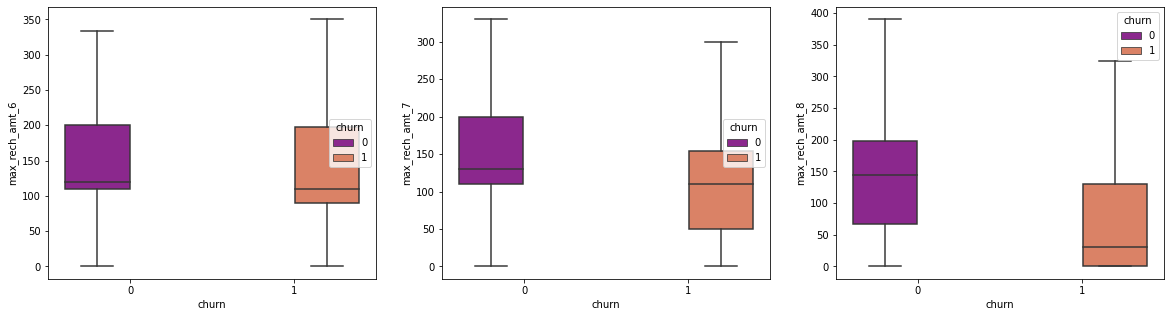

In [ ]:
plot_box_plot(telecom,rech_columns[3:6],figSize=(20,5))

There is huge drop in the maximum recharge amount for the churned case in Action Phase (8th Month)

#### Other recharge related variables

In [ ]:
# Recharge related columns
other_rech_columns = telecom.columns[telecom.columns.str.contains('rech_num|max_rech_data', regex=True)]
other_rech_columns

Index(['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8'],
      dtype='object')

Lets now check missing values for these columns

In [ ]:
other_recharge_cols_null_check = pd.DataFrame(telecom.loc[:,other_rech_columns].isnull().sum()/len(telecom) * 100)
other_recharge_cols_null_check.rename(columns={0:'Missing_Vals'}, inplace=True)

In [ ]:
other_recharge_cols_null_check = other_recharge_cols_null_check.style.applymap(apply_color)
other_recharge_cols_null_check

,Missing_Vals
total_rech_num_6,0.000000
total_rech_num_7,0.000000
total_rech_num_8,0.000000
max_rech_data_6,44.112443
max_rech_data_7,43.117551
max_rech_data_8,46.799987


In [ ]:
max_rech_data_cols = other_rech_columns[3:]
max_rech_data_cols

Index(['max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8'], dtype='object')

In [ ]:
telecom.loc[:, max_rech_data_cols].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,16740.000000,17038.000000,15935.000000
mean,139.804002,140.444712,136.353373
std,118.892926,120.295284,119.571138
min,1.000000,1.000000,1.000000
25%,25.000000,25.000000,25.000000
50%,152.000000,152.000000,152.000000
75%,198.000000,198.000000,198.000000
max,1555.000000,1555.000000,1555.000000


We see that the minimum value is '1' and maximum value is '1555' across all the months for max_rech_data, which could mean that missing values are ones where there was no recharge done. So we can impute the value zero for these columns

In [ ]:
telecom[max_rech_data_cols] = telecom[max_rech_data_cols].fillna(0)

In [ ]:
other_recharge_cols_null_check = pd.DataFrame(telecom.loc[:,other_rech_columns].isnull().sum()/len(telecom) * 100)
other_recharge_cols_null_check.rename(columns={0:'Missing_Vals'}, inplace=True)
other_recharge_cols_null_check = other_recharge_cols_null_check.style.applymap(apply_color)
other_recharge_cols_null_check

,Missing_Vals
total_rech_num_6,0.000000
total_rech_num_7,0.000000
total_rech_num_8,0.000000
max_rech_data_6,0.000000
max_rech_data_7,0.000000
max_rech_data_8,0.000000


So all the missing values are imputed

##### 1. Total recharge number

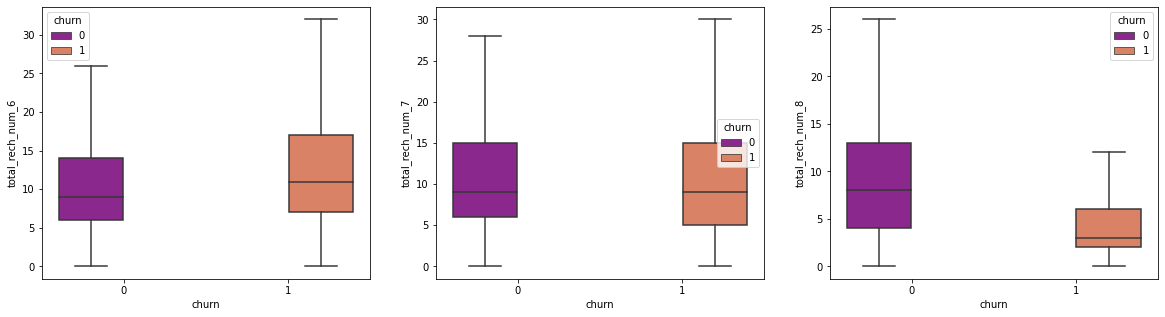

In [ ]:
plot_box_plot(telecom,other_rech_columns[0:3],figSize=(20,5))

There is drop in the total recharge number for the churned case in Action Phase (8th Month)

##### 2. maximum recharge data

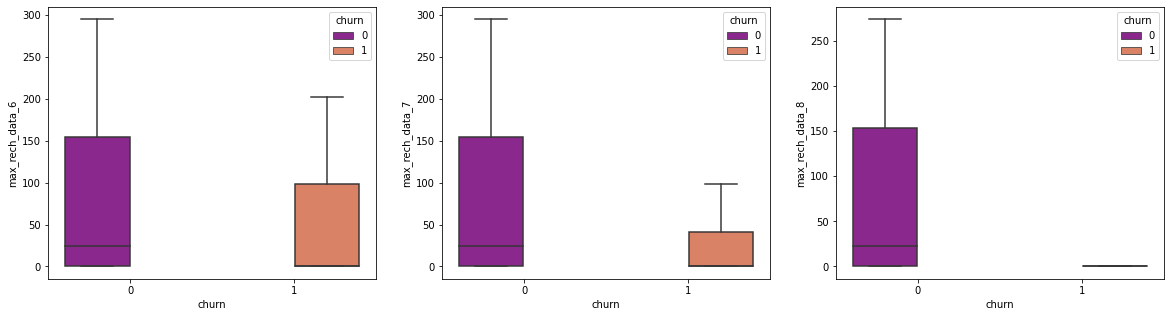

In [ ]:
plot_box_plot(telecom,max_rech_data_cols,figSize=(20,5))

There is a gradual drop across months for maximum recharge data and drops to a significant level in the Action Phase(8th Month)

#### Last Day Recharge amount

In [ ]:
last_day_rech_amt_cols = telecom.columns[telecom.columns.str.contains('last_day')]
last_day_rech_amt_cols

Index(['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8'], dtype='object')

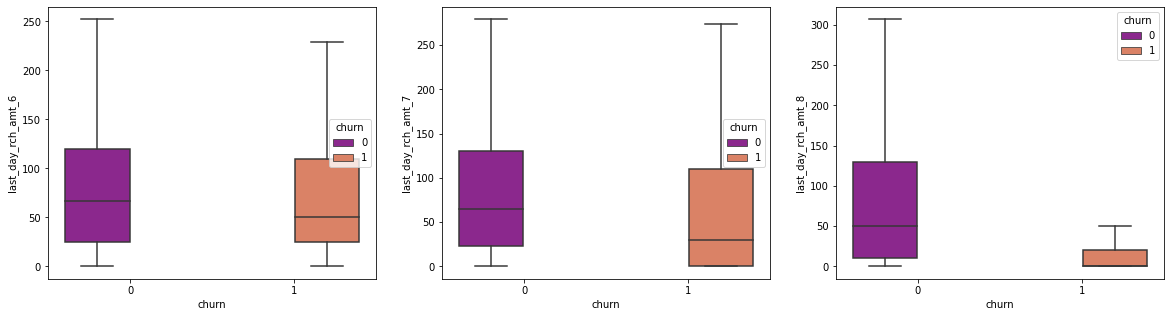

In [ ]:
plot_box_plot(telecom,last_day_rech_amt_cols,figSize=(20,5))

There is huge drop in the last day recharge amount for the churned case in Action Phase (8th Month)

#### 2G and 3G related attributes

In [ ]:
usage_2g_3g_cols = telecom.columns[telecom.columns.str.contains('2g|3g', regex=True)]
usage_2g_3g_cols

Index(['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'vol_2g_mb_6',
       'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6',
       'arpu_2g_7', 'arpu_2g_8', 'monthly_2g_6', 'monthly_2g_7',
       'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8',
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'sep_vbc_3g'],
      dtype='object')

In [ ]:
# let us check missing values
usage_2g_3g_cols_check = pd.DataFrame(telecom.loc[:,usage_2g_3g_cols].isnull().sum()/len(telecom) * 100)
usage_2g_3g_cols_check.rename(columns={0:'Missing_Vals'}, inplace=True)
usage_2g_3g_cols_check = usage_2g_3g_cols_check.style.applymap(apply_color)
usage_2g_3g_cols_check

,Missing_Vals
count_rech_2g_6,44.112443
count_rech_2g_7,43.117551
count_rech_2g_8,46.799987
count_rech_3g_6,44.112443
count_rech_3g_7,43.117551
count_rech_3g_8,46.799987
vol_2g_mb_6,0.000000
vol_2g_mb_7,0.000000
vol_2g_mb_8,0.000000
vol_3g_mb_6,0.000000


We see there is more than 40% of the data missing for columns


*   Recharge count for 2G and 3G
*   Average revenue per user for 2G and 3G

We could drop these columns because imputing will be hard



In [ ]:
cols_2_drop = telecom.columns[telecom.columns.str.contains('count_rech|arpu_[0-9]{1}g', regex=True)]
cols_2_drop

Index(['count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'arpu_3g_6',
       'arpu_3g_7', 'arpu_3g_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')

In [ ]:
telecom.drop(cols_2_drop, axis=1, inplace=True)

In [ ]:
print('Number of Columns after removing columns : {}'.format(len(telecom.columns)))

Number of Columns after removing columns : 152


##### 1. 2G/3G usage

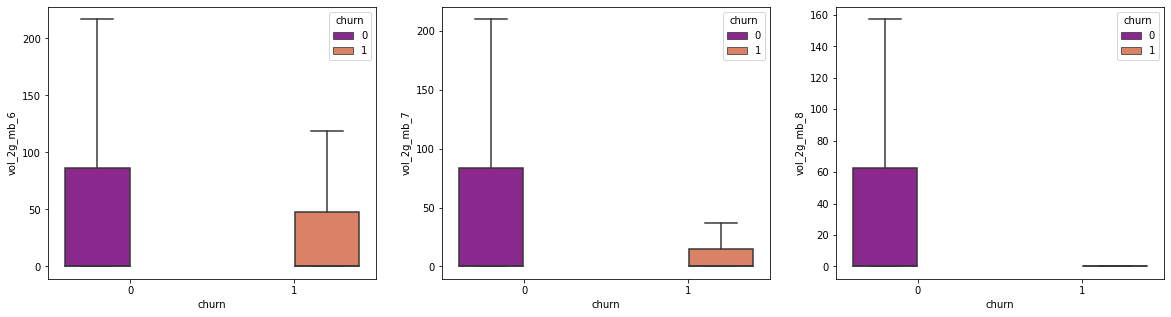

In [ ]:
vol_2g_mb = telecom.columns[telecom.columns.str.contains('vol_2g_mb')]
plot_box_plot(telecom,vol_2g_mb,figSize=(20,5))

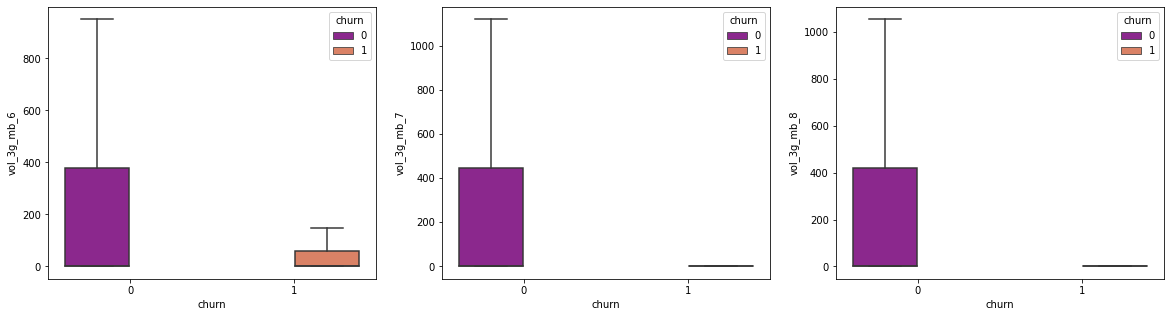

In [ ]:
vol_3g_mb = telecom.columns[telecom.columns.str.contains('vol_3g_mb')]
plot_box_plot(telecom,vol_3g_mb,figSize=(20,5))

1. 2G and 3G usage of the churned customers are low in Action Phase(8th Month)
2. In general the churned customers have lower usage of 2G and 3G. It could also indicate that the areas where 2G/3G services is not good there are more chances of churning

##### 2. 2G/3G Monthly Subscription

In [ ]:
mnth_2g_3g_sub = telecom.columns[telecom.columns.str.contains('monthly_[0-9]{1}g', regex=True)]
mnth_2g_3g_sub

Index(['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6',
       'monthly_3g_7', 'monthly_3g_8'],
      dtype='object')

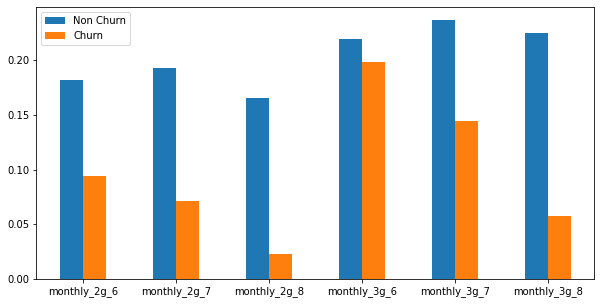

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.181613,0.193096,0.165080,0.219840,0.236882,0.224891
Churn,0.093711,0.071106,0.023017,0.198109,0.144266,0.057131


In [ ]:
plot_bar_chart(telecom, mnth_2g_3g_sub)

There is a gradual drop in monthly subscription for both 2G and 3G  over months for churned customers

#### Volume based Cost

In [ ]:
# volume based cost  columns
vbc_columns = telecom.columns[telecom.columns.str.contains('vbc_')]
vbc_columns

Index(['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'], dtype='object')

The columns do not follow the usual convention of numbers. Let us change it

In [ ]:
mapper =  {
            'jun_vbc_3g':'vbc_3g_6',
            'jul_vbc_3g':'vbc_3g_7',
            'aug_vbc_3g':'vbc_3g_8',
            'sep_vbc_3g':'vbc_3g_9'
          }
telecom.rename(columns=mapper, inplace=True)

In [ ]:
# we can drop the 9th month column
telecom.drop('vbc_3g_9', axis=1, inplace=True)

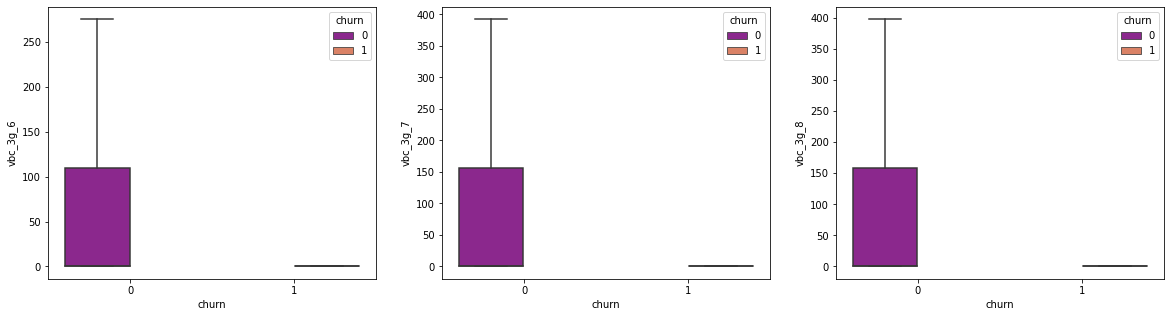

In [ ]:
# volume based cost  columns
vbc_columns = telecom.columns[telecom.columns.str.contains('vbc_')].tolist()
vbc_columns.sort()
plot_box_plot(telecom,vbc_columns,figSize=(20,5))

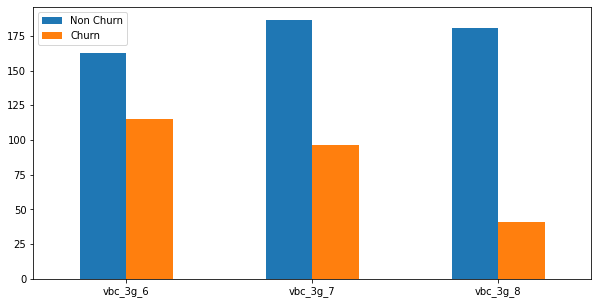

,vbc_3g_6,vbc_3g_7,vbc_3g_8
Non Churn,162.557305,186.370503,180.622636
Churn,115.461780,96.340707,40.940884


In [ ]:
plot_bar_chart(telecom, vbc_columns)

1. Volume based cost for 3G is significantly lower for churned cases
2. Value is lower for 8th month

#### Service Schemes less than a month

In [ ]:
SC_2g_3g = telecom.columns[telecom.columns.str.contains('sachet_[0-9]{1}g', regex=True)]
SC_2g_3g

Index(['sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8'],
      dtype='object')

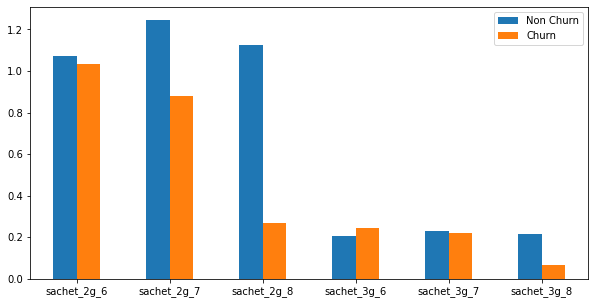

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churn,1.070531,1.245203,1.125145,0.206577,0.228307,0.214571
Churn,1.032470,0.879984,0.270859,0.244554,0.221948,0.065351


In [ ]:
plot_bar_chart(telecom, SC_2g_3g)

1. Service schemes usage drop significantly during the Action Phase(8th month)

#### Average Revenue per user

In [ ]:
arpu_cols = telecom.columns[telecom.columns.str.contains('arpu_')]
arpu_cols

Index(['arpu_6', 'arpu_7', 'arpu_8'], dtype='object')

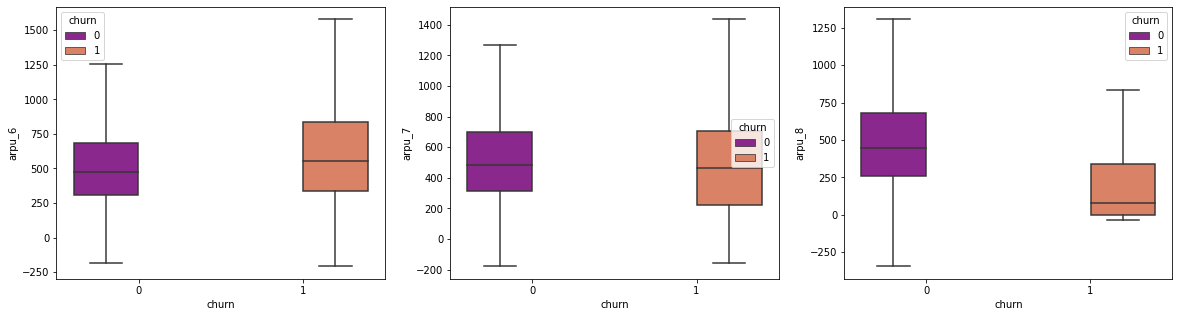

In [ ]:
plot_box_plot(telecom,arpu_cols,figSize=(20,5))

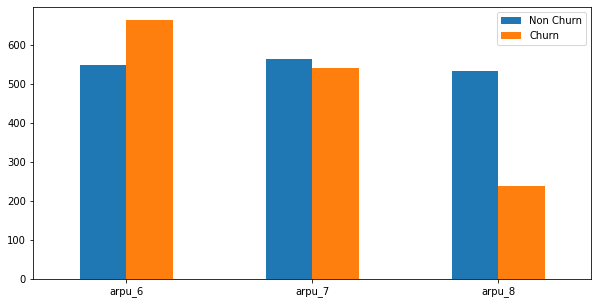

,arpu_6,arpu_7,arpu_8
Non Churn,549.546959,562.929990,532.869746
Churn,663.709368,541.146131,237.655478


In [ ]:
plot_bar_chart(telecom, arpu_cols)

There is a significant drop in the values for Average revenue per user for churned cases

#### Minutes of Usage

In [ ]:
mou_cols = telecom.columns[telecom.columns.str.contains('mou')]
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mo

In [ ]:
# missing values analysis for minutes of usage
mou_cols_check = pd.DataFrame(telecom.loc[:,mou_cols].isnull().sum()/len(telecom) * 100)
mou_cols_check.rename(columns={0:'Missing_Vals'}, inplace=True)
mou_cols_check = mou_cols_check.style.applymap(apply_color)
mou_cols_check

,Missing_Vals
onnet_mou_6,1.809502
onnet_mou_7,1.789470
onnet_mou_8,3.912797
offnet_mou_6,1.809502
offnet_mou_7,1.789470
offnet_mou_8,3.912797
roam_ic_mou_6,1.809502
roam_ic_mou_7,1.789470
roam_ic_mou_8,3.912797
roam_og_mou_6,1.809502


The maximum missing percentage is around 3.91. It could also mean that the customer has not used the services

So we can impute '0' for missing values

In [ ]:
telecom[mou_cols] = telecom[mou_cols].fillna(0)

##### Minutes of Usage for Outgoing

###### Month-6

In [ ]:
mou_og_cols6 = telecom.columns[telecom.columns.str.contains('.*_og_.*mou_6', regex=True)]

In [ ]:
telecom[mou_og_cols6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,26.596033,84.574122,163.309546,6.348347,1.577380,254.240239,165.897941,179.439168,1.806292,347.147123,2.174995,5.825077,610.058005
std,116.274169,228.962993,250.218928,22.139546,6.308138,378.546516,403.990737,409.143255,11.988810,608.845412,45.888834,17.579228,691.178402
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.380000,19.210000,0.000000,0.000000,32.260000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,116.640000
50%,0.000000,24.360000,77.260000,0.000000,0.000000,124.590000,2.710000,16.360000,0.000000,45.080000,0.000000,0.230000,410.630000
75%,0.000000,78.060000,209.030000,4.230000,0.000000,332.310000,109.560000,154.540000,0.000000,465.290000,0.000000,5.210000,859.030000
max,3775.110000,6431.330000,4729.740000,1466.030000,271.440000,10643.380000,7366.580000,8314.760000,628.560000,8432.990000,5900.660000,1023.210000,10674.030000


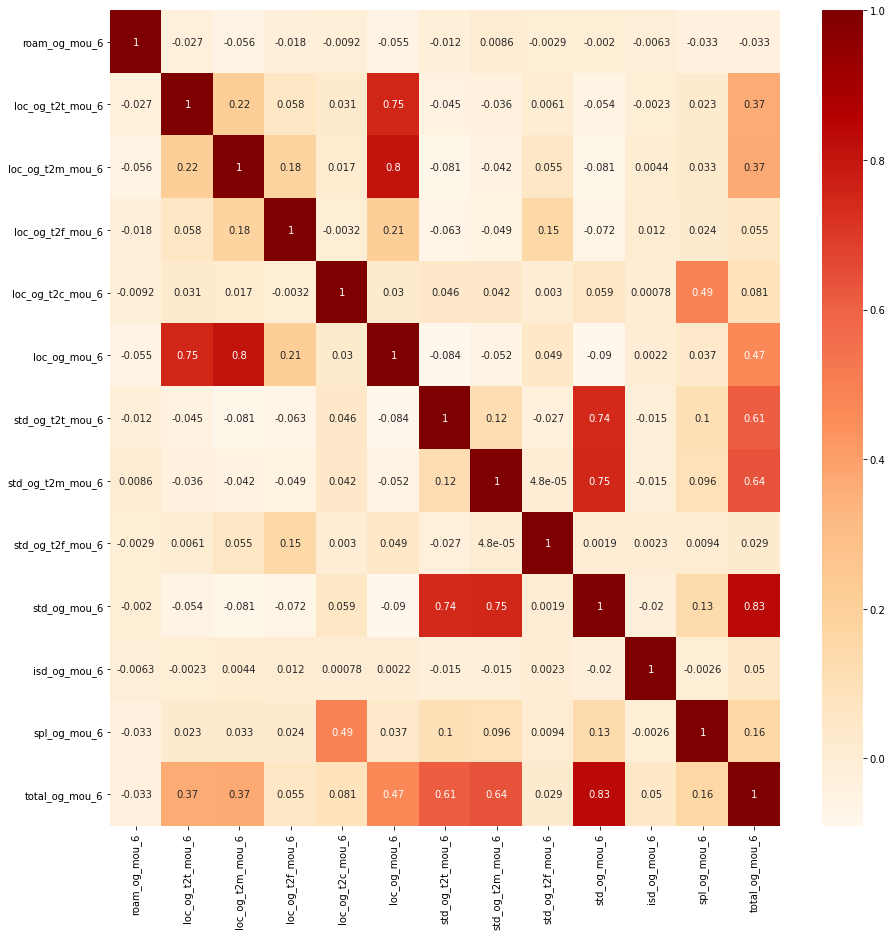

In [ ]:
plot_heat_map(telecom.filter(mou_og_cols6))

###### Month-7

In [ ]:
mou_og_cols7 = telecom.columns[telecom.columns.str.contains('.*_og_.*mou_7', regex=True)]

In [ ]:
telecom[mou_og_cols7].describe()

,roam_og_mou_7,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,loc_og_mou_7,std_og_t2t_mou_7,std_og_t2m_mou_7,std_og_t2f_mou_7,std_og_mou_7,isd_og_mou_7,spl_og_mou_7,total_og_mou_7
count,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,20.155134,85.762835,163.087606,6.426493,1.888737,255.285293,174.378166,187.961923,1.828363,364.172169,2.109014,7.106715,628.724108
std,96.134144,240.702116,241.683234,21.957189,9.143628,375.617344,421.470201,433.808121,12.990380,640.128871,45.581631,21.768942,717.567954
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.630000,20.490000,0.000000,0.000000,34.510000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,116.590000
50%,0.000000,24.680000,78.990000,0.100000,0.000000,128.060000,2.680000,16.060000,0.000000,44.030000,0.000000,0.710000,425.640000
75%,0.000000,78.510000,208.530000,4.380000,0.100000,333.540000,116.530000,160.260000,0.000000,499.690000,0.000000,6.950000,891.990000
max,2812.040000,7400.660000,4557.140000,1196.430000,569.710000,7674.780000,8133.660000,9284.740000,544.630000,10936.730000,5490.280000,1265.790000,11365.310000


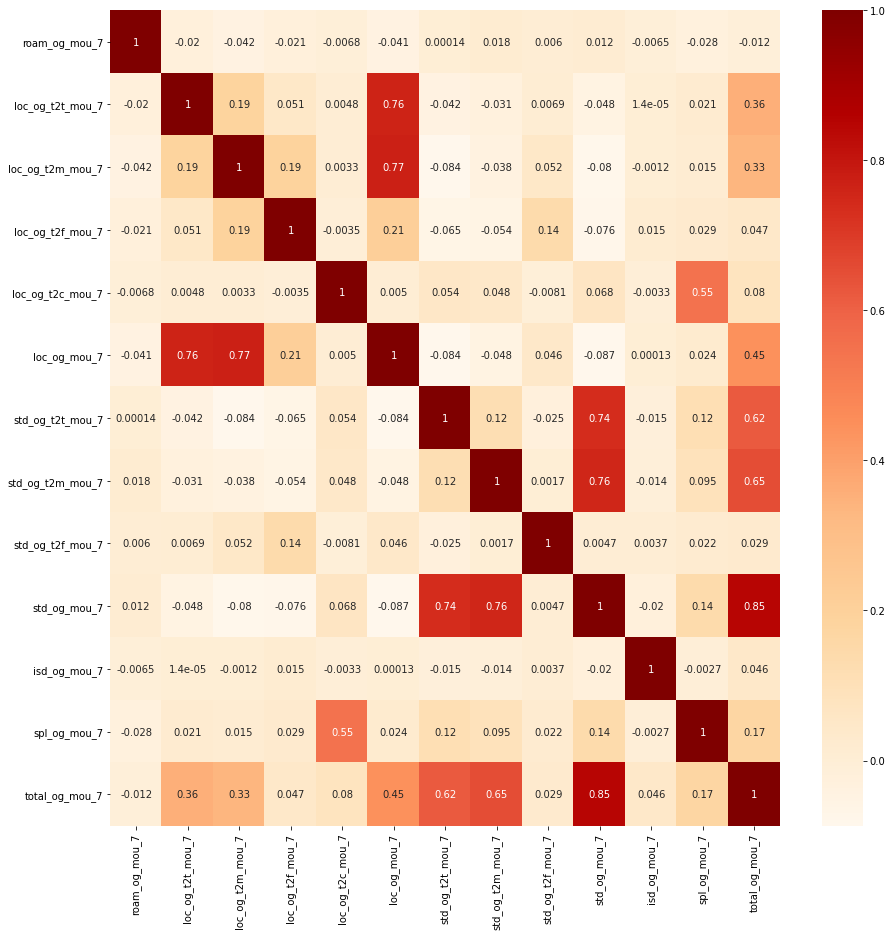

In [ ]:
plot_heat_map(telecom.filter(mou_og_cols7))

###### Month-8

In [ ]:
mou_og_cols8 = telecom.columns[telecom.columns.str.contains('.*_og_.*mou_8', regex=True)]

In [ ]:
telecom[mou_og_cols8].describe()

,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,total_og_mou_8
count,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,19.889295,78.153334,151.810056,5.891865,1.701889,235.863120,148.587258,157.322964,1.586742,307.500304,1.952078,6.549024,551.929765
std,104.799622,227.540167,233.745412,19.516259,7.147606,363.548405,397.838396,409.035684,10.940142,609.109928,44.747769,20.289977,700.585424
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.540000,13.130000,0.000000,0.000000,22.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.490000
50%,0.000000,20.740000,67.790000,0.000000,0.000000,111.010000,0.630000,9.460000,0.000000,25.560000,0.000000,0.430000,333.610000
75%,0.000000,72.130000,197.030000,3.930000,0.010000,310.680000,78.190000,117.710000,0.000000,357.240000,0.000000,6.140000,775.380000
max,5337.040000,10752.560000,4961.330000,928.490000,351.830000,11039.910000,8014.430000,13950.040000,516.910000,13980.060000,5681.540000,954.510000,14043.060000


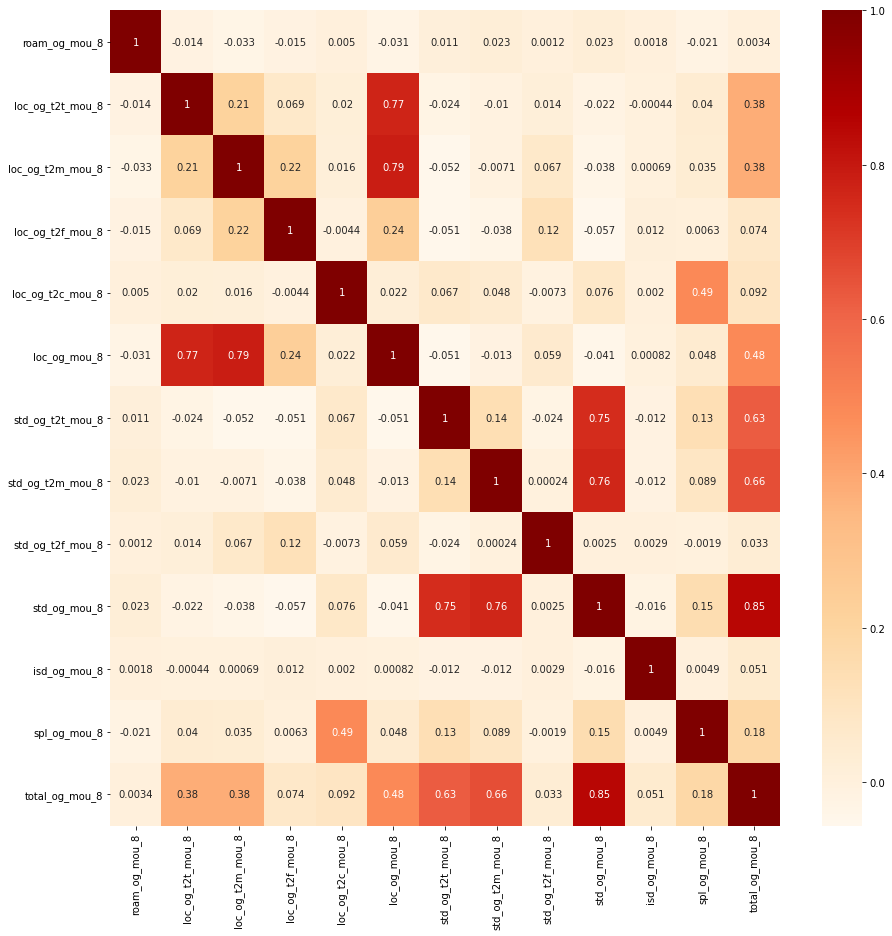

In [ ]:
plot_heat_map(telecom.filter(mou_og_cols8))

###### Remove High Correlated columns

In [ ]:
highCorrCols = remove_collinear_features(telecom.filter(mou_og_cols8.tolist() + ['churn']), 'churn',0.7)
highCorrCols

['total_og_mou_8', 'loc_og_mou_8', 'std_og_mou_8']

since the correlation for all the months are similar, we can drop all these 3 columns for all the 3 months

In [ ]:
regex = '|'.join([col[:-1] for col in highCorrCols])
cols_2_drop = telecom.columns[telecom.columns.str.contains(regex, regex=True)]
cols_2_drop

Index(['loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_mou_6',
       'std_og_mou_7', 'std_og_mou_8', 'total_og_mou_6', 'total_og_mou_7',
       'total_og_mou_8'],
      dtype='object')

In [ ]:
telecom.drop(cols_2_drop,axis=1, inplace=True)

##### Minutes of Usage for Incoming

###### Month-6

In [ ]:
mou_ic_cols6 = telecom.columns[telecom.columns.str.contains('.*_ic_.*mou_6', regex=True)]

In [ ]:
telecom[mou_ic_cols6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,16.124001,65.508916,150.474219,15.291721,231.284489,14.896832,29.212448,2.698829,46.811695,290.121569,0.061047,10.800999
std,76.344227,163.855393,219.321437,45.785255,315.005426,77.750215,98.279300,19.114766,137.597749,365.739944,0.188124,76.789627
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.100000,28.090000,0.000000,47.910000,0.000000,0.000000,0.000000,1.030000,72.890000,0.000000,0.000000
50%,0.000000,25.080000,84.110000,1.840000,134.560000,0.380000,5.000000,0.000000,11.410000,183.780000,0.000000,0.000000
75%,0.000000,67.480000,188.740000,11.980000,297.260000,8.190000,23.630000,0.110000,41.490000,372.160000,0.000000,0.000000
max,2613.310000,6351.440000,4693.860000,1678.410000,7454.630000,5459.560000,4630.230000,1351.110000,5459.630000,7716.140000,19.760000,6789.410000


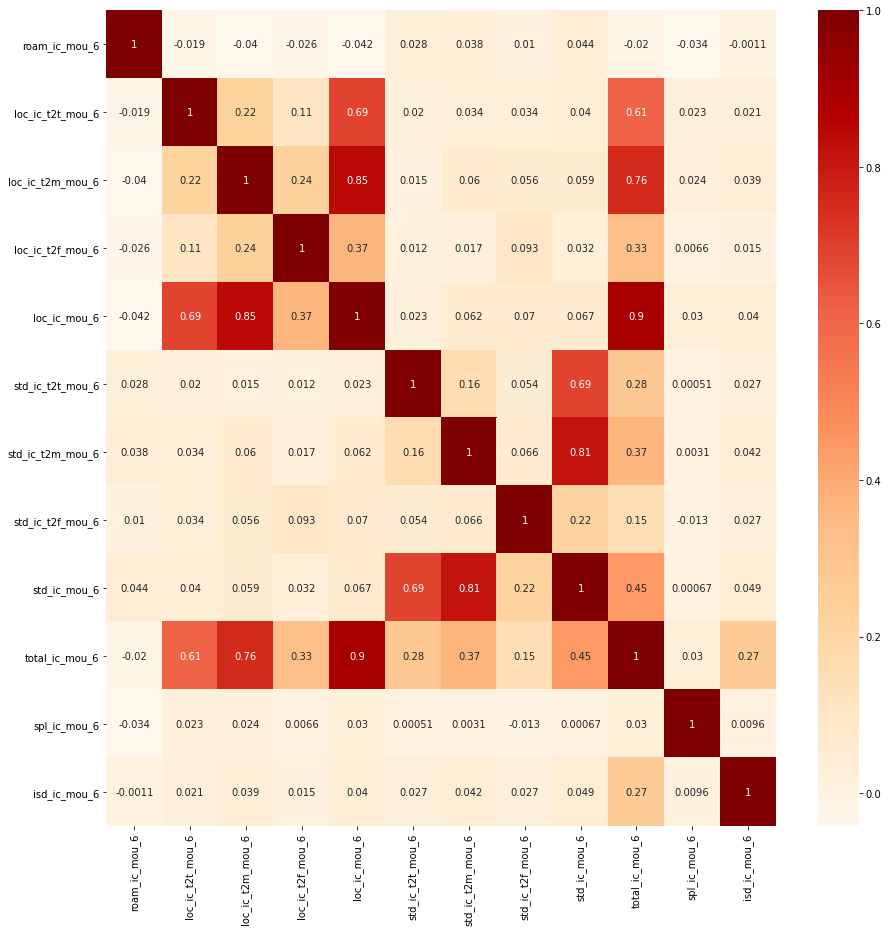

In [ ]:
plot_heat_map(telecom.filter(mou_ic_cols6))

###### Month-7

In [ ]:
mou_ic_cols7 = telecom.columns[telecom.columns.str.contains('.*_ic_.*mou_7', regex=True)]

In [ ]:
telecom[mou_ic_cols7].describe()

,roam_ic_mou_7,loc_ic_t2t_mou_7,loc_ic_t2m_mou_7,loc_ic_t2f_mou_7,loc_ic_mou_7,std_ic_t2t_mou_7,std_ic_t2m_mou_7,std_ic_t2f_mou_7,std_ic_mou_7,total_ic_mou_7,spl_ic_mou_7,isd_ic_mou_7
count,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,12.646145,66.686921,151.712177,16.046447,234.455252,15.432838,30.828347,2.801822,49.066658,296.944240,0.019767,11.893198
std,75.833558,167.521866,218.367498,49.201697,316.177938,83.106360,105.685760,19.529757,148.231218,373.950048,0.181984,80.242156
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.790000,30.840000,0.000000,52.540000,0.000000,0.000000,0.000000,1.050000,79.030000,0.000000,0.000000
50%,0.000000,25.780000,85.690000,2.000000,137.660000,0.450000,5.180000,0.000000,12.090000,187.710000,0.000000,0.000000
75%,0.000000,68.730000,190.740000,12.240000,298.780000,8.590000,24.960000,0.200000,43.840000,377.560000,0.000000,0.000000
max,3813.290000,5709.590000,4171.510000,1983.010000,6466.740000,5800.930000,3470.380000,1136.080000,6745.760000,7442.860000,21.330000,4747.910000


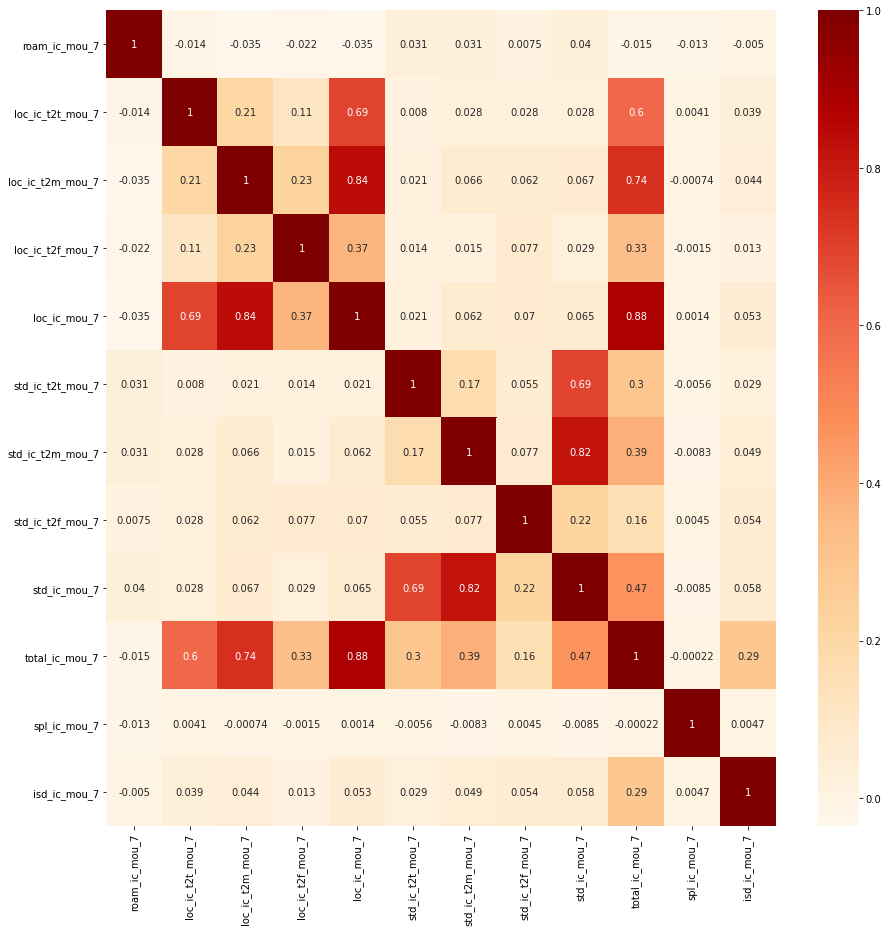

In [ ]:
plot_heat_map(telecom.filter(mou_ic_cols7))

###### Month-8

In [ ]:
mou_ic_cols8 = telecom.columns[telecom.columns.str.contains('.*_ic_.*mou_8', regex=True)]
telecom[mou_ic_cols8].describe()

,roam_ic_mou_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,total_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8
count,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000,29953.000000
mean,12.512269,62.662397,146.303887,14.414880,223.390506,13.919836,27.920360,2.564944,44.408522,280.074127,0.026548,11.015061
std,74.179181,159.026025,214.996335,43.335424,308.483647,71.387685,103.374423,19.912581,138.876998,361.356861,0.110617,70.655796
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.880000,24.230000,0.000000,40.540000,0.000000,0.000000,0.000000,0.410000,61.490000,0.000000,0.000000
50%,0.000000,22.610000,80.040000,1.680000,128.790000,0.110000,3.710000,0.000000,9.290000,173.160000,0.000000,0.000000
75%,0.000000,65.110000,185.830000,11.160000,285.480000,7.060000,21.830000,0.090000,38.380000,361.990000,0.000000,0.000000
max,4169.810000,4003.210000,4643.490000,1588.530000,5388.740000,4309.290000,5645.860000,1394.890000,5957.140000,6066.630000,6.230000,3432.880000


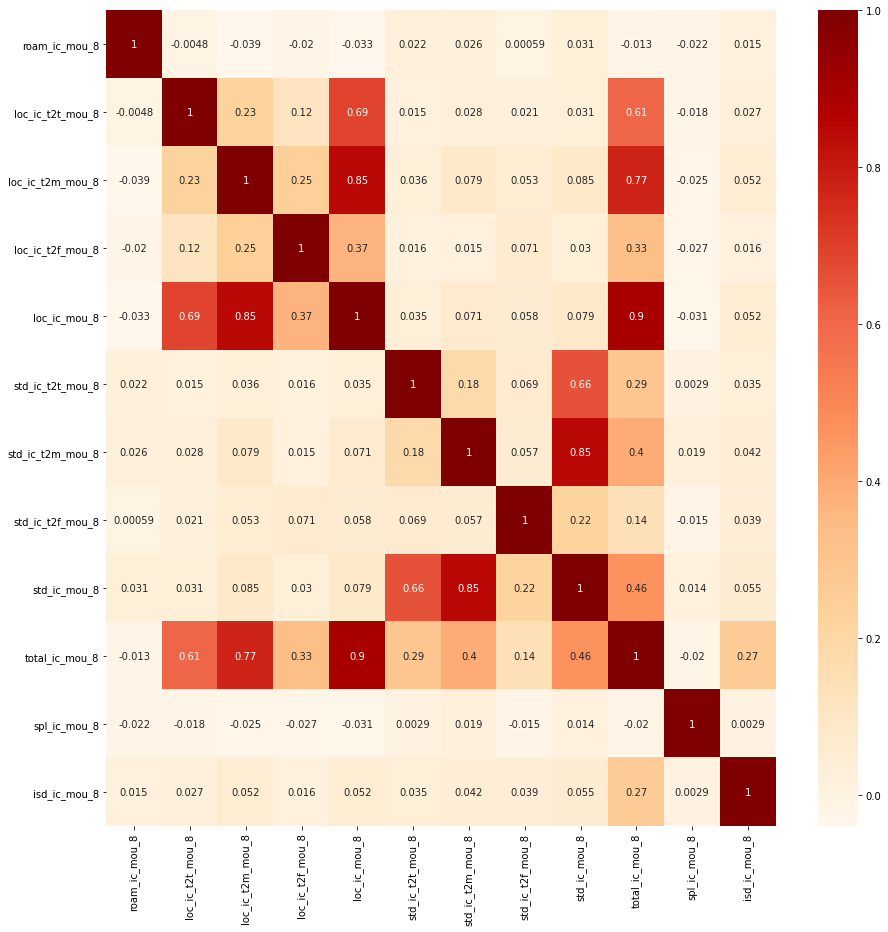

In [ ]:
plot_heat_map(telecom.filter(mou_ic_cols8))

since the correlation for all the months are similar, we can drop all these 3 columns for all the 3 months

###### Remove High Correlated columns

In [ ]:
highCorrCols = remove_collinear_features(telecom.filter(mou_ic_cols8.tolist() + ['churn']), 'churn',0.7)
highCorrCols

['loc_ic_mou_8', 'total_ic_mou_8', 'std_ic_mou_8']

In [ ]:
regex = '|'.join([col[:-1] for col in highCorrCols])
cols_2_drop = telecom.columns[telecom.columns.str.contains(regex, regex=True)]
cols_2_drop

Index(['loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_mou_6',
       'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7',
       'total_ic_mou_8'],
      dtype='object')

In [ ]:
telecom.drop(cols_2_drop,axis=1, inplace=True)

##### ONNET - Calls within the same operator network

In [ ]:
onnet_usage_cols =  telecom.columns[telecom.columns.str.contains('^onnet.*mou',regex=True)]
onnet_usage_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8'], dtype='object')

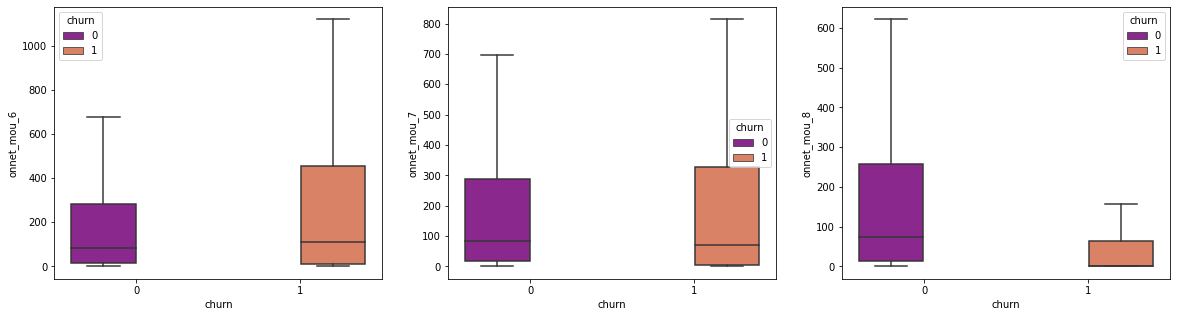

In [ ]:
plot_box_plot(telecom,onnet_usage_cols,figSize=(20,5))

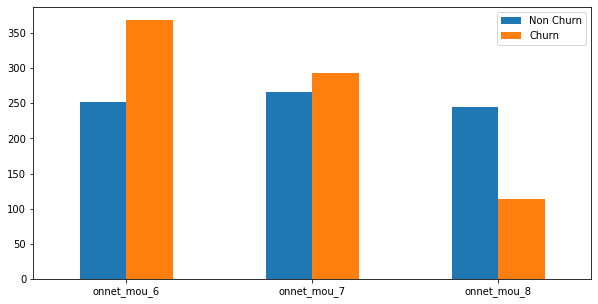

,onnet_mou_6,onnet_mou_7,onnet_mou_8
Non Churn,251.374116,265.859670,245.030935
Churn,368.659420,292.846601,113.478011


In [ ]:
plot_bar_chart(telecom, onnet_usage_cols)

On Net usage is generally very high for the churned case but drastically decreases during the Action Phase (8th month)

##### OFFNET - Calls outside the operator T network

In [ ]:
offnet_usage_cols =  telecom.columns[telecom.columns.str.contains('^offnet.*mou',regex=True)]
offnet_usage_cols

Index(['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], dtype='object')

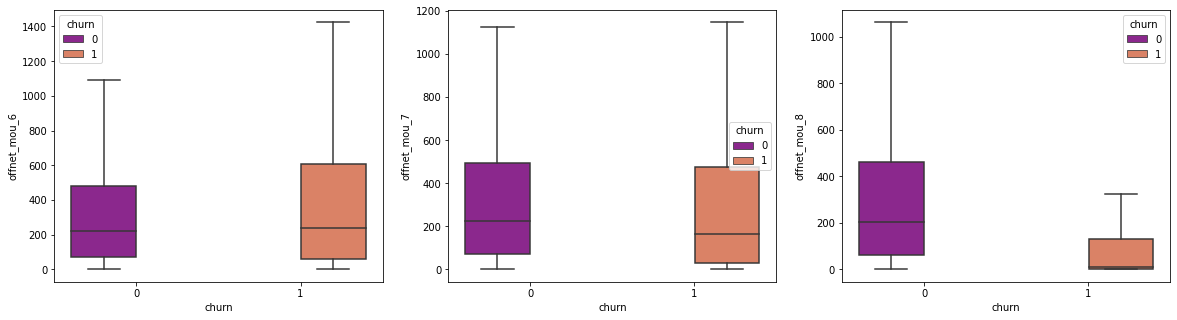

In [ ]:
plot_box_plot(telecom,offnet_usage_cols,figSize=(20,5))

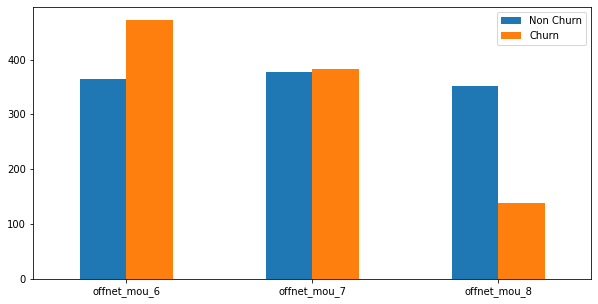

,offnet_mou_6,offnet_mou_7,offnet_mou_8
Non Churn,365.123076,377.875572,352.504090
Churn,471.950838,382.277222,138.523181


In [ ]:
plot_bar_chart(telecom, offnet_usage_cols)

Off Net usage is drastically reduces during the Action Phase (8th month)

#### Tenure Analysis

let us use 'aon' -> age on network variable to get the tenure

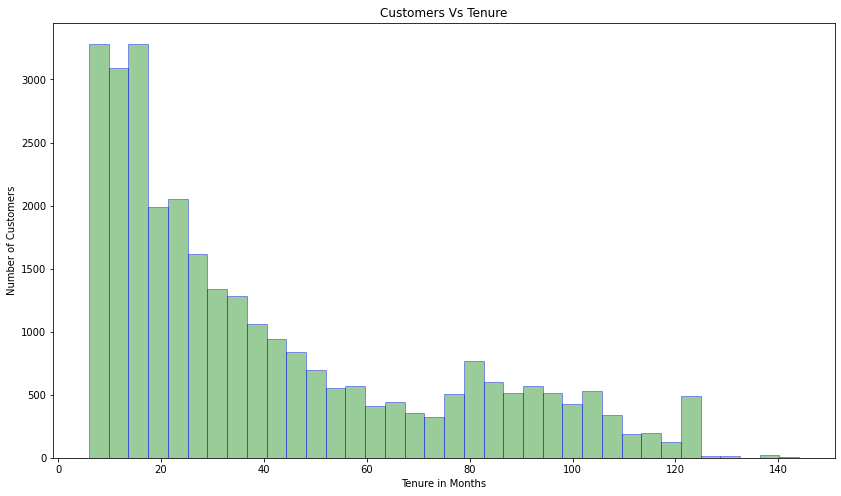

In [ ]:
tenure_data = telecom[['aon', 'churn']]
plt.figure(figsize=(14,8))
tenure_data['tenure'] = tenure_data['aon'] / 30
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'blue'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [ ]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): [0-6 Months < 6-12 Months < 1-2 Yrs < 2-5 Yrs < 5 Yrs and above]

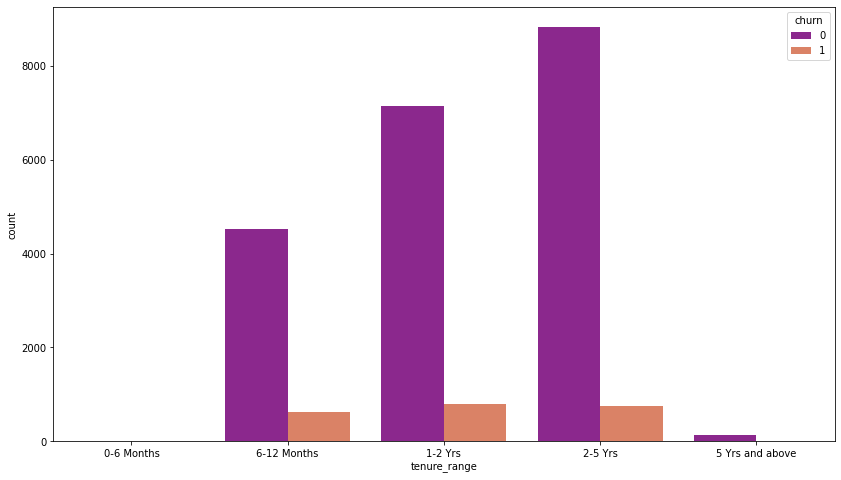

In [ ]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("plasma"))
plt.show()

## Missing Value Analysis

In [ ]:
missing_values = pd.DataFrame(telecom.isnull().sum()/len(telecom) * 100)
missing_values.rename(columns={0:'Missing_Vals'}, inplace=True)

In [ ]:
missing_values_gt_30 = missing_values[missing_values['Missing_Vals'] > 30]
missing_values_gt_30.sort_values(["Missing_Vals"], axis=0,ascending=False)

,Missing_Vals
date_of_last_rech_data_8,46.799987
night_pck_user_8,46.799987
fb_user_8,46.799987
date_of_last_rech_data_6,44.112443
night_pck_user_6,44.112443
fb_user_6,44.112443
date_of_last_rech_data_7,43.117551
night_pck_user_7,43.117551
fb_user_7,43.117551


In [ ]:
missing_values_gt_30.index

Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'night_pck_user_6', 'night_pck_user_7',
       'night_pck_user_8', 'fb_user_6', 'fb_user_7', 'fb_user_8'],
      dtype='object')

In [ ]:
# drop the columns
telecom.drop(missing_values_gt_30.index, axis=1, inplace=True)

In [ ]:
telecom.shape

(29953, 124)

In [ ]:
missing_values = pd.DataFrame(telecom.isnull().sum()/len(telecom) * 100)
missing_values.rename(columns={0:'Missing_Vals'}, inplace=True)
missing_values = missing_values[missing_values['Missing_Vals'] > 0]
missing_values.sort_values(["Missing_Vals"], axis=0,ascending=False)

,Missing_Vals
og_others_8,3.912797
ic_others_8,3.912797
date_of_last_rech_8,1.943044
og_others_6,1.809502
ic_others_6,1.809502
og_others_7,1.789470
ic_others_7,1.789470
date_of_last_rech_7,0.327179
date_of_last_rech_6,0.243715


We can impute with values zero for numeric columns as there are less than 4% values missing

In [ ]:
missing_num_cols = [col for col in missing_values.index if 'date' not in col]
missing_num_cols

['og_others_6',
 'og_others_7',
 'og_others_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8']

In [ ]:
telecom[missing_num_cols] = telecom[missing_num_cols].fillna(0)

In [ ]:
missing_values = pd.DataFrame(telecom.isnull().sum()/len(telecom) * 100)
missing_values.rename(columns={0:'Missing_Vals'}, inplace=True)
missing_values = missing_values[missing_values['Missing_Vals'] > 0]
missing_values.sort_values(["Missing_Vals"], axis=0,ascending=False)

,Missing_Vals
date_of_last_rech_8,1.943044
date_of_last_rech_7,0.327179
date_of_last_rech_6,0.243715


## Final data

In [ ]:
telecom.shape

(29953, 124)

### Drop Date columns

In [ ]:
telecom.drop(telecom.filter(regex='date_').columns,axis=1,inplace=True)

### Merge columns of 'Good Phase'

merge columns of month 6 and 7 and take average of the values and drop the 6th and 7th month columns

In [ ]:
col_list = telecom.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print('col : "{}" is getting merged'.format(col))
    avg_col_name = col+"_6_7"
    col_6 = col+"_6"
    col_7 = col+"_7"
    telecom[avg_col_name] = (telecom[col_6]  + telecom[col_7])/ 2
    telecom.drop([col_6, col_7], axis=1, inplace=True)

col : "arpu" is getting merged
col : "onnet_mou" is getting merged
col : "offnet_mou" is getting merged
col : "roam_ic_mou" is getting merged
col : "roam_og_mou" is getting merged
col : "loc_og_t2t_mou" is getting merged
col : "loc_og_t2m_mou" is getting merged
col : "loc_og_t2f_mou" is getting merged
col : "loc_og_t2c_mou" is getting merged
col : "std_og_t2t_mou" is getting merged
col : "std_og_t2m_mou" is getting merged
col : "std_og_t2f_mou" is getting merged
col : "isd_og_mou" is getting merged
col : "spl_og_mou" is getting merged
col : "og_others" is getting merged
col : "loc_ic_t2t_mou" is getting merged
col : "loc_ic_t2m_mou" is getting merged
col : "loc_ic_t2f_mou" is getting merged
col : "std_ic_t2t_mou" is getting merged
col : "std_ic_t2m_mou" is getting merged
col : "std_ic_t2f_mou" is getting merged
col : "spl_ic_mou" is getting merged
col : "isd_ic_mou" is getting merged
col : "ic_others" is getting merged
col : "total_rech_num" is getting merged
col : "total_rech_amt" is 

In [ ]:
telecom.shape

(29953, 82)

We have now reduced to 82 features (81 predictor variable and 1 outcome variable)

## Distribution of data of Churn class

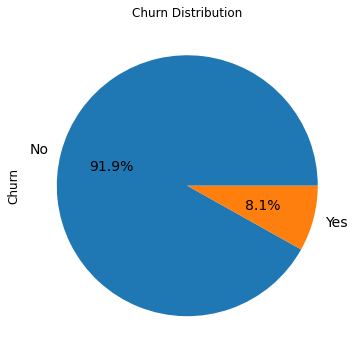

In [ ]:
#Churn Distribution
pie_chart = telecom['churn'].value_counts()*100.0 /len(telecom)
ax = pie_chart.plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(8,6), fontsize = 14 )                                                                           
ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)
plt.show()

## Spit data (Predictor variable vs Outcome variable)

In [ ]:
y = telecom['churn']
X = telecom.drop(['churn', 'mobile_number'],axis=1)

## train- test split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# since data is highly imbalanced, better to use stratify option
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=100,
                                                    stratify=y)

In [ ]:
print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [ ]:
X_train.to_pickle(drivePath + 'X_train.pkl')
X_test.to_pickle(drivePath + 'X_test.pkl')
y_train.to_pickle(drivePath + 'y_train.pkl')
y_test.to_pickle(drivePath + 'y_test.pkl')